In [24]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [25]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const nm2au = 18.897

18.897

In [26]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [27]:
σ = 10*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [28]:
function discretize(sd::fitsd, num_osc::Int)
    return sd.ωs, (sd.jws.^(0.5))
end

discretize (generic function with 1 method)

In [29]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

In [30]:
ϵ0 = -5000*mev2invcm # This appears to not change the dynamics at all
ϵb = 300

300

In [31]:
N = 4

4

In [32]:
H0 = Matrix{ComplexF64}(zeros(N, N))

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [33]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
end

In [34]:
H0 = H0 * invcm2au

4×4 Matrix{ComplexF64}:
 -0.183757+0.0im  0.0013669+0.0im        0.0+0.0im        0.0+0.0im
 0.0013669+0.0im  -0.183757+0.0im  0.0013669+0.0im        0.0+0.0im
       0.0+0.0im  0.0013669+0.0im  -0.183757+0.0im  0.0013669+0.0im
       0.0+0.0im        0.0+0.0im  0.0013669+0.0im  -0.183757+0.0im

In [35]:
#ωp = [265.6, 823.7, 1054.6, 1195.4, 1234.5, 1443.2, 1572.8] .* invcm2au
#g0p = [107.0, -126.0, -178.2, -246.2, -467.9, 819.7, 761.2] .* invcm2au
#jws = (g0p.^(2))
#wm = maximum(ωp)
Jw = SpectralDensities.DrudeLorentz(λ=100*invcm2au, γ=50*invcm2au, Δs=1.0)

QuantumDynamics.SpectralDensities.DrudeLorentz(0.00045563300000000005, 0.00022781650000000002, 1.0, 0.22781650000000003, false)

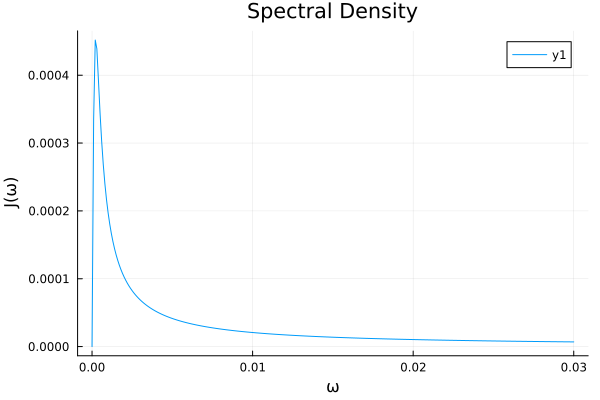

In [36]:
ω = 0:0.0001:0.03
plot(ω, Jw.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density")

In [37]:
nsteps = 50
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[1, 1] = 1

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [38]:
dt = 20/au2fs

826.8274915150198

In [39]:
#fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
#t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

In [43]:
d = 0.05 * nm2au  # Intermolecular distance between pentacene molecules (10.1088/2632-959X/abbcad)

0.94485

In [44]:
## QCPI Run

ω, c = SpectralDensities.discretize(Jw, 100)
hb = Solvents.HarmonicBath(β, ω, c, [1.0, 2.0, 3.0, 4.0].*d, 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0].*d, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

(0.0:826.8274915150198:41341.37457575099, [1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.24221587683107773 + 0.0im -0.10190658285664896 - 0.3288624983411705im -0.1269790857332327 + 0.1572618700590042im 0.07584253061504703 - 0.012724210675377783im; … ; 0.42395213147421124 - 1.3499340155548323e-17im -0.5796595657686 - 0.002013752492320876im 0.44678470830314415 - 0.030060572700722175im -0.23944259753046282 + 0.043944242387325645im; 0.388304026704965 + 2.6077426312450364e-18im -0.5927074602645267 + 0.01383704487104811im 0.44779028483602773 - 0.023089829460680847im -0.22375479070840984 + 0.03510661839082683im;;; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.10190658285664896 + 0.3288624983411705im 0.5179956222344899 + 0.0im -0.17752686191893263 - 0.26454104280170115im -0.017389700001104194 + 0.12602629231888354im; … ; -0.5796595657686 + 0.0020137524923208873im 0.5453740006986577 + 4.4774946923662684e-18im -0.260231614890712 + 0.012314937588895672im 0.08093006702454064 - 0.0048417

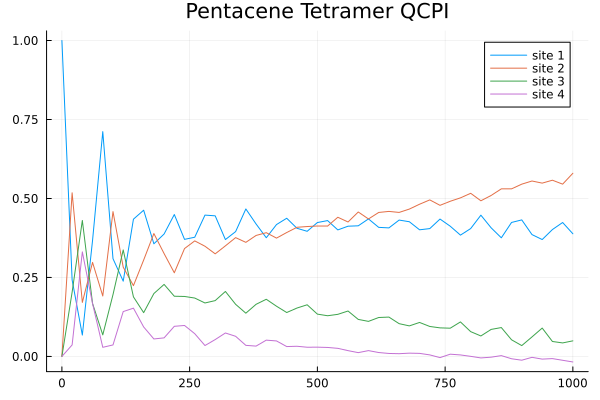

In [45]:
plot(tc.*au2fs, real.(ρc[:, 1, 1]), label="site 1")
plot!(tc.*au2fs, real.(ρc[:, 2, 2]), label="site 2")
plot!(tc.*au2fs, real.(ρc[:, 3, 3]), label="site 3")
plot!(tc.*au2fs, real.(ρc[:, 4, 4]), label="site 4", title="Pentacene Tetramer QCPI")